<a href="https://colab.research.google.com/github/aayushdD/Art-generation/blob/master/ArtGeneration_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
from google.colab import drive



In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from PIL import Image
import glob
import cv2

In [5]:
image_list=[]

In [ ]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
ll=os.walk(os.path.join(os.getcwd(),'drive\resized\resized'))

In [7]:
import numpy as np

In [ ]:
for i , j , k in ll:
    path=i.split(os.sep)
    print(path)

In [9]:
images=[]
for i , j , k in os.walk(os.path.join(os.getcwd(),'drive/MyDrive/resized/resized')):
    image_list=os.listdir(i)
    for image in image_list:
        instance=cv2.imread(os.path.join(i,image))
        instance=cv2.cvtColor(instance, cv2.COLOR_BGR2RGB)
        ins=cv2.resize(instance,(64,64)).astype('float32')
        ins=ins-127.5/127.5
        images.append(ins)

images=np.array(images)
    
    

'/content'

In [11]:
images.shape

(8683, 64, 64, 3)

In [12]:
np.save(os.path.join(os.getcwd(),'drive/MyDrive/art_gen_training_64'),images)

In [14]:
images=np.load('drive/MyDrive/art_gen_training_64.npy')
print(images.shape)

(8683, 64, 64, 3)


In [15]:
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
len(images)

8683

In [ ]:
images[0].shape

(64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


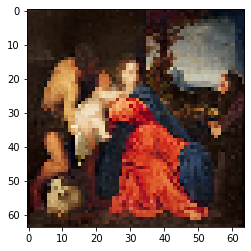

In [16]:
plt.imshow(images[0].astype(np.int32))

In [17]:
discriminator=keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=4,strides=2, padding='same', input_shape=[64,64,3]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(128,kernel_size=4,strides=2,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(256,kernel_size=4,strides=2,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    # keras.layers.Conv2D(512,kernel_size=4,strides=2,padding='same'),
    # keras.layers.BatchNormalization(),
    # keras.layers.LeakyReLU(),
    
    keras.layers.Conv2D(1,kernel_size=1,strides=1,padding='valid',activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')
   
])

In [18]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0

In [19]:
latent_size=128
batch_size=32

In [28]:

from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model

In [31]:
GENERATE_RES=2
seed_size=100

In [30]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [32]:
generator=build_generator(seed_size,3)

In [20]:

generator=keras.models.Sequential([
    keras.layers.Conv2DTranspose(512,kernel_size=4,strides=1,padding='valid',use_bias=False, input_shape=[1,1,latent_size]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
   

    keras.layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(128,kernel_size=4,strides=2,
                                padding='same'),
    keras.layers.BatchNormalization(),
   keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(64,kernel_size=4,strides=2,
                                padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    # keras.layers.Conv2DTranspose(32,kernel_size=4,strides=4,
    #                             padding='same'),
    # keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(3,kernel_size=4,strides=2,
                                padding='same',activation='tanh'),
    # keras.layers.LeakyReLU()
    
])

In [ ]:
from keras import layers

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())

model.add(layers.Reshape((7, 7, 256)))
assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert model.output_shape == (None, 7, 7, 128)
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())

model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert model.output_shape == (None, 14, 14, 64)
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Conv2DTranspose(3, (1, 1), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert model.output_shape == (None, 28, 28, 3)


In [ ]:
generator=model

In [33]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 8, 8, 256)        

In [34]:
cross_entropy=keras.losses.BinaryCrossentropy()

In [35]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

    

In [36]:
def generator_loss(fake_output):
    gen_loss=cross_entropy(tf.ones_like(fake_output),fake_output)
    return gen_loss

In [37]:
gen_opt=keras.optimizers.Adam()
dis_opt=keras.optimizers.Adam()
batch_size=32

In [38]:
@tf.function
def train_step(images):
    noise=tf.random.normal([batch_size,seed_size])
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as dis_tape:
        gen_images=generator(noise,training=True)
        
        real_output=discriminator(images,training=True)
        fake_output=discriminator(gen_images,training=True)
        
        gen_loss=generator_loss(fake_output)
        dis_loss=discriminator_loss(real_output,fake_output)
        
    gen_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
    dis_gradients=dis_tape.gradient(dis_loss,discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_gradients,generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))
    
    return gen_loss, dis_loss,gen_images[0]

In [39]:
import time
from IPython import display

In [40]:
def train_tot(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()      
    for image_batch in dataset:
      gen_loss,dis_loss,gen_img=train_step(image_batch)    
    print(gen_loss,dis_loss)
  return gen_img
    

In [41]:

buffer=600

In [42]:
dataset=tf.data.Dataset.from_tensor_slices(images).shuffle(buffer).batch(batch_size)


In [43]:
for element in dataset.take(1):
    print(element)

tf.Tensor(
[[[[166. 137.  98.]
   [162. 127.  78.]
   [180. 146. 108.]
   ...
   [178. 144.  96.]
   [236. 217. 174.]
   [175. 153. 122.]]

  [[215. 176. 128.]
   [184. 142.  91.]
   [173. 134.  85.]
   ...
   [184. 150.  99.]
   [209. 179. 137.]
   [210. 183. 138.]]

  [[202. 161. 105.]
   [189. 141.  87.]
   [200. 155. 109.]
   ...
   [210. 171. 126.]
   [206. 170. 119.]
   [210. 183. 135.]]

  ...

  [[ 49.  45.  40.]
   [ 49.  50.  43.]
   [ 44.  42.  39.]
   ...
   [ 90.  81.  75.]
   [ 96.  80.  68.]
   [109.  96.  76.]]

  [[ 67.  67.  65.]
   [109.  94.  81.]
   [ 66.  57.  50.]
   ...
   [ 91.  78.  62.]
   [102.  86.  68.]
   [120. 110.  94.]]

  [[116. 118. 116.]
   [108.  92.  80.]
   [ 84.  70.  65.]
   ...
   [ 92.  79.  63.]
   [119. 106.  90.]
   [137. 127. 108.]]]


 [[[222. 187. 138.]
   [207. 171. 112.]
   [225. 191. 128.]
   ...
   [183. 137. 101.]
   [179. 134.  91.]
   [189. 144. 103.]]

  [[213. 181. 124.]
   [213. 179. 123.]
   [212. 177. 119.]
   ...
   [175. 1

In [44]:
vg=train_tot(dataset,150)

tf.Tensor(0.6505485, shape=(), dtype=float32) tf.Tensor(1.3982577, shape=(), dtype=float32)
tf.Tensor(3.074967, shape=(), dtype=float32) tf.Tensor(0.6585977, shape=(), dtype=float32)
tf.Tensor(3.4066312, shape=(), dtype=float32) tf.Tensor(0.24154961, shape=(), dtype=float32)
tf.Tensor(1.4805129, shape=(), dtype=float32) tf.Tensor(0.671314, shape=(), dtype=float32)
tf.Tensor(2.5119991, shape=(), dtype=float32) tf.Tensor(0.29689512, shape=(), dtype=float32)
tf.Tensor(13.508314, shape=(), dtype=float32) tf.Tensor(0.02300247, shape=(), dtype=float32)
tf.Tensor(1.0523325, shape=(), dtype=float32) tf.Tensor(1.3320695, shape=(), dtype=float32)
tf.Tensor(1.2293358, shape=(), dtype=float32) tf.Tensor(2.355649, shape=(), dtype=float32)
tf.Tensor(2.4967103, shape=(), dtype=float32) tf.Tensor(0.49444038, shape=(), dtype=float32)
tf.Tensor(4.341091, shape=(), dtype=float32) tf.Tensor(0.17206886, shape=(), dtype=float32)
tf.Tensor(1.7709824, shape=(), dtype=float32) tf.Tensor(0.51971257, shape=(), d

In [51]:
noise=generator(tf.random.normal([1,seed_size]),training=False)[0]

In [46]:
vg=np.array(vg*127.5+127.5)

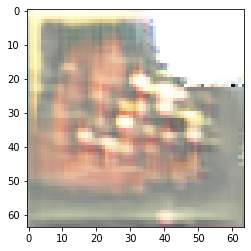

In [49]:
plt.imshow(vg.astype(np.int32))

(7,)

In [52]:
noise

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.98019624, 0.95354223, 0.89293283],
        [0.9997174 , 0.9954433 , 0.9143914 ],
        [0.9999876 , 0.9996409 , 0.9668043 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 0.99999964]],

       [[0.9902596 , 0.9852182 , 0.9412743 ],
        [0.99995714, 0.99898654, 0.9292905 ],
        [0.9999988 , 0.9999328 , 0.9717636 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.95342934, 0.9516308 , 0.86970717],
        [0.9996879 , 0.9936953 , 0.81117344],
        [0.99998486, 0.99929005, 0.9255726 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.9999972 , 0.9997892 , 0.992425  ],
        [1.    

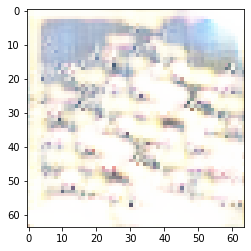

In [55]:
import matplotlib.pyplot as plt
import sys
plt.imshow((np.array(noise)*127.5+127.5).astype(np.int32))

In [ ]:
nn=np.array((noise))

In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
np.save(os.path.join(os.getcwd(),'gg'),nn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


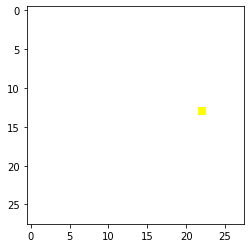

In [ ]:
plt.imshow(images[10])

In [ ]:
import cv2

In [ ]:
while True:
    cv2.imshow(noise)
    cv2.waitKey(0)
    sys.exit() # to exit from all the processes
 
cv2.destroyAllWindows() # destroy all windows

DisabledFunctionError: ignored